# Importy

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

from importlib import reload

### DataLoader
import DataLoader.xAPIConnector
reload(DataLoader.xAPIConnector)
from DataLoader.xAPIConnector import *

import DataLoader.DataLoader
reload(DataLoader.DataLoader)
from DataLoader.DataLoader import *

from DataLoader.config import user_id, pwd


### Data
import Data.SymbolParser
reload(Data.SymbolParser)
from Data.SymbolParser import parse_symbols


### TrendAnalysis
import TrendAnalysis.MACD
reload(TrendAnalysis.MACD)
from TrendAnalysis.MACD import MACD

import TrendAnalysis.MA
reload(TrendAnalysis.MA)
from TrendAnalysis.MA import MA

import TrendAnalysis.RSI
reload(TrendAnalysis.RSI)
from TrendAnalysis.RSI import RSI

### MeanRevert
import MeanRevert.MeanRevert
reload(MeanRevert.MeanRevert)
from MeanRevert.MeanRevert import MeanRevert


### TechFunctions
from TechFunctions.Technicalities import position_encoding

# Właściwy kod

In [2]:
Symbols = parse_symbols()

In [3]:
symbols = Symbols['silver']
start, interval = '2020-01-01', '1D'

dl = DataLoader(user_id, pwd)
data = dl.getData(symbols=symbols, start_date=start, interval=interval, verbose=False)

[BŁĄD] Nie pobrano AG.US
[BŁĄD] Nie pobrano AYASF.US
[BŁĄD] Nie pobrano HL.US


## Podsumowanie generowania sygnałów

Umiemy już generować tabele z sygnałami na bazie strategii trend-following i mean-reverting.

In [4]:
for s in [-1.0, 0.0, 1.0]:
    s_str = position_encoding[int(s)]
    
    model = MA(data)
    print(f"Sygnały {s_str} z modelu MA:\n{(model.Decision()==s).sum()}")

    model = MACD(data)
    print(f"Sygnały {s_str} z modelu MACD:\n{(model.Decision()==s).sum()}")

    model = RSI(data)
    print(f"Sygnały {s_str} z modelu RSI:\n{(model.Decision()==s).sum()}")
    
    model = MeanRevert(data)
    print(f"Sygnały {s_str} z modelu Mean-Revert:\n{(model.Decision()==s).sum()}")
    
    print()

Sygnały sell z modelu MA:
MAG.US     19
SVM.US     15
EXK.US     16
FSM.US     21
ASM.US     17
PAAS.US    20
WPM.US     24
dtype: int64
Sygnały sell z modelu MACD:
MAG.US     14
SVM.US     13
EXK.US     15
FSM.US     13
ASM.US     14
PAAS.US    14
WPM.US     15
dtype: int64
Sygnały sell z modelu RSI:
MAG.US     4
SVM.US     1
EXK.US     5
FSM.US     7
ASM.US     4
PAAS.US    4
WPM.US     4
dtype: int64
Sygnały sell z modelu Mean-Revert:
MAG.US     58
SVM.US     57
EXK.US     68
FSM.US     61
ASM.US     62
PAAS.US    56
WPM.US     46
dtype: int64

Sygnały hold z modelu MA:
MAG.US     1292
SVM.US     1300
EXK.US     1298
FSM.US     1288
ASM.US     1296
PAAS.US    1290
WPM.US     1282
dtype: int64
Sygnały hold z modelu MACD:
MAG.US     1302
SVM.US     1304
EXK.US     1300
FSM.US     1304
ASM.US     1302
PAAS.US    1302
WPM.US     1300
dtype: int64
Sygnały hold z modelu RSI:
MAG.US     1303
SVM.US     1297
EXK.US     1295
FSM.US     1295
ASM.US     1297
PAAS.US    1300
WPM.US     1297
dty

In [53]:
model = MeanRevert(data)

symbol = data.columns[0]
y = data.loc[:, symbol]
signal = model.Decision().loc[:, symbol]

In [54]:
data_to_backtest = pd.DataFrame([y, signal]).T.dropna()
data_to_backtest.columns = ['price', 'signal']
data_to_backtest['sl'] = ((data_to_backtest['signal'] != 0)*1.0).shift(-1)
data_to_backtest['tp'] = 0.0
data_to_backtest

,price,signal,sl,tp
Date,,,,
2020-01-02,11.50,0.0,0.0,0.0
2020-01-03,11.36,0.0,0.0,0.0
2020-01-06,11.28,0.0,0.0,0.0
2020-01-07,11.29,0.0,0.0,0.0
2020-01-08,10.92,0.0,0.0,0.0
...,...,...,...,...
2025-01-23,14.92,0.0,0.0,0.0
2025-01-24,15.12,0.0,0.0,0.0
2025-01-27,14.41,0.0,0.0,0.0


In [55]:
from TechFunctions.Technicalities import backtest_strategy

backtest_data = backtest_strategy(data_to_backtest, 'price', 'sl', 'tp', 'signal')
backtest_data

,entry_index,exit_index,entry_price,exit_price,pnl,reason
0,2020-01-17,2020-02-06,10.52,10.58,-0.06,Stop-loss hit
1,2020-02-07,2020-02-12,10.33,10.32,0.01,Stop-loss hit
2,2020-02-13,2020-03-05,10.25,9.13,1.12,Stop-loss hit
3,2020-03-06,2020-04-08,8.58,8.47,0.11,Stop-loss hit
4,2020-04-09,2020-04-24,9.63,9.63,0.00,Stop-loss hit
...,...,...,...,...,...,...
105,2024-10-15,2024-12-12,15.58,15.30,-0.28,Stop-loss hit
106,2024-12-13,2024-12-27,14.88,13.72,1.16,Stop-loss hit
107,2024-12-30,2024-12-31,13.37,13.58,-0.21,Stop-loss hit
108,2025-01-02,2025-01-03,14.30,14.03,-0.27,Stop-loss hit


<AxesSubplot: xlabel='exit_index'>

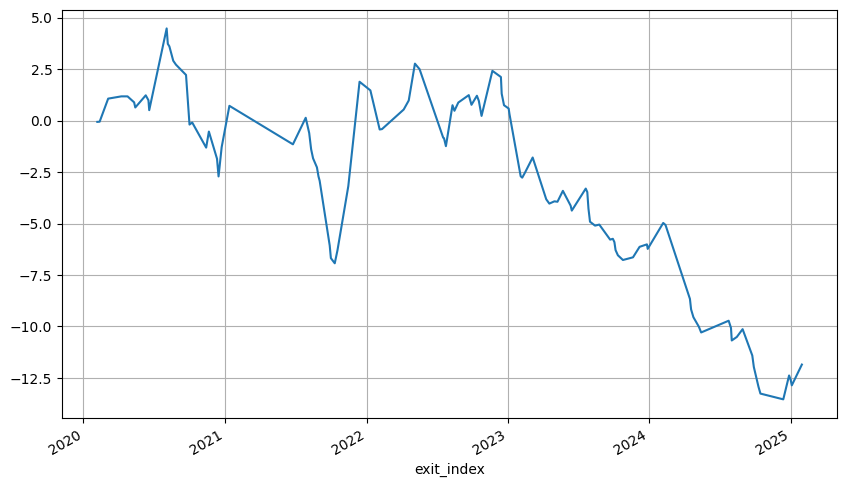

In [56]:
pnl = pd.Series(backtest_data['pnl'])
pnl.index = backtest_data['exit_index']
pnl.cumsum().plot(figsize=(10, 6), grid=True)